In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
import cmasher as cmr
import seaborn as sns

In [69]:
import os
import glob

try:
    common_folder_path = r"D:\OXFORD\Data\2025-01-31_fluorescence_Seb\\"
    bg_shotlist = glob.glob(common_folder_path + "\\" + r"bg\\*" + 'tif' + r"*")
    if len(bg_shotlist) == 0:
        raise FileNotFoundError("Path not found!")
except FileNotFoundError:
    print("Path not found!")  

print(bg_shotlist)
    

pressures = [7,9,12,15,17,19,21,23,25,27,29,32,34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68,70,72,74,76,78,80,82,84,86,88,90,92,94,96,98,100]    
print(f"Pressures: {pressures}")

['D:\\OXFORD\\Data\\2025-01-31_fluorescence_Seb\\\\\\bg\\ser1_X1.tif', 'D:\\OXFORD\\Data\\2025-01-31_fluorescence_Seb\\\\\\bg\\ser1_X10.tif', 'D:\\OXFORD\\Data\\2025-01-31_fluorescence_Seb\\\\\\bg\\ser1_X2.tif', 'D:\\OXFORD\\Data\\2025-01-31_fluorescence_Seb\\\\\\bg\\ser1_X3.tif', 'D:\\OXFORD\\Data\\2025-01-31_fluorescence_Seb\\\\\\bg\\ser1_X4.tif', 'D:\\OXFORD\\Data\\2025-01-31_fluorescence_Seb\\\\\\bg\\ser1_X5.tif', 'D:\\OXFORD\\Data\\2025-01-31_fluorescence_Seb\\\\\\bg\\ser1_X6.tif', 'D:\\OXFORD\\Data\\2025-01-31_fluorescence_Seb\\\\\\bg\\ser1_X7.tif', 'D:\\OXFORD\\Data\\2025-01-31_fluorescence_Seb\\\\\\bg\\ser1_X8.tif', 'D:\\OXFORD\\Data\\2025-01-31_fluorescence_Seb\\\\\\bg\\ser1_X9.tif']
Pressures: [7, 9, 12, 15, 17, 19, 21, 23, 25, 27, 29, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]


In [70]:
avg_sigs = np.zeros(len(pressures))

#avg_sigs_fri = np.zeros(len(pressures))

def load_and_calculate_average(filenames):
    # Initialize an empty array to store pixel values
    total_sum = None
    # Iterate over each filename
    for filename in filenames:
        # Load the image
        image = cv2.imread(filename, -1)
        # If this is the first image, initialize total_sum with zeros
        if total_sum is None:
            total_sum = np.zeros_like(image, dtype=np.uint64)
        # Add the pixel values of the current image to the total_sum
        total_sum += image.astype(np.uint64)
    # Calculate the average pixel value
    if total_sum is None:
        return None
    else:
        average_image = total_sum / len(filenames)
        average_image.astype(image.dtype)
        
    return average_image

def get_avg_signal_angled(shotlist: list[str], 
                          bg_shotlist: list[str],
                          coords_start: list[int] = [50, 50],
                          coords_stop: list[int] = [500, 500],
                          plot_flag: bool = True,
                          title: str = "Fluorescence camera angled",
                          max_pixel_value: int or str = 2**12,
                          line_start_x: int = 0,
                          line_stop_x: int = 500, 
                          average_start_x: int = 0,
                          average_stop_x: int = 500, 
                          number_of_line_averages: int = 5, ## Number of lineouts around to average over (1 = 3 lines)
                          x_min_zoom: int = 0, ## Zoom section of the window
                          x_max_zoom: int = 800,
                          y_min_zoom: int = 0,
                          y_max_zoom: int = 600):
    
    x_start = coords_start[0]
    y_start = coords_start[1]
    x_stop = coords_stop[0]
    y_stop = coords_stop[1]

    line_grad = (y_stop - y_start) / (x_stop - x_start) ## Gradient of the line
    line_intercept = y_start - line_grad * x_start ## Intercept of the line with the y-axis (coordinate system defined by the camera)
    line_len = np.sqrt((x_stop - x_start)**2 + (y_stop - y_start)**2) ## Length of the line

    if len(shotlist) == 0:
        return 0
    else:
        average_image = load_and_calculate_average(shotlist) ## Load and average the images
        average_image_bg = load_and_calculate_average(bg_shotlist) ## Load and average the background images
        if average_image_bg is None: ## If no background images found, run without background removal
            print("No background images found, running without background removal...")
            im = average_image
        else:
            im = average_image - average_image_bg ## Background removal (avg image - avg bg image)
            
        im[im<0] = 0 ## Remove negative pixel values
        x_min, x_max = 0, len(im[0])
        y_min, y_max = 0, len(im)
                
        
        if str(max_pixel_value) == "auto": ## If max pixel value is set to auto, calculate the max pixel value
            max_pixel_value = np.max(im) ## Max pixel value for the colormap
        
        lneqn = lambda x, m, c: m*x + c     ## Line section for following the plasma channel (y = mx + c)        
        lineoutlist = []
        for i in range(-number_of_line_averages, number_of_line_averages, 1): ## Average over a number of lines
            spectra = [] ## List to store the lineouts
            for j in range(x_start, x_stop, 1): #
                y = round(lneqn(j, line_grad, line_intercept+i)) 
                if y > y_max: ## If the line goes out of the image, set the value to the edge of the image
                    y = y_max  
                elif y < 0: ## If the line goes out of the image, set the value to the edge of the image
                    y = 0
                val = im[y][j]
                spectra.append(val) ## Append the pixel value to the lineout list
            lineoutlist.append(spectra) ## Append the lineout to the list of lineouts
            
        lineout = np.mean(lineoutlist, axis=0) ## Average over the lineouts
        avg_sig = np.mean(lineout[average_start_x:average_stop_x])

        if plot_flag:
            fig, axs = plt.subplots(1,2, figsize=(12,5))
            axs[0].imshow(im, aspect='auto', origin='lower', vmin=0, vmax=max_pixel_value, cmap=cmr.torch_r) ## Plot the image
            axs[0].scatter([x_start, x_stop], [y_start, y_stop], color='tab:green', s=10) ## Plot the start and stop points of the line
            axs[0].plot([x_start, x_stop], [y_start, y_stop], color='tab:green', linewidth=1, linestyle=(0, (1, 10))) ## Plot the line following the plasma channel

            axs[0].set_xlim(x_min_zoom, x_max_zoom) ## Zoom in the image
            axs[0].set_ylim(y_min_zoom, y_max_zoom) ## Zoom in the image
            axs[0].set_xlabel('X [pix]')
            axs[0].set_ylabel('Y [pix]')

            axs[1].plot(lineout) ## Plot the lineout
            axs[1].set_xlim(line_start_x, line_stop_x)
            axs[1].set_ylim(0, max_pixel_value)
            
            axs[1].axvline(average_start_x,ls='dotted',color='black')
            axs[1].axvline(average_stop_x,ls='dotted',color='black')
            axs[1].set_title('lineout: avg fluorescence signal')
            axs[1].set_xlabel('loc [pix]')
            axs[1].set_ylabel('avg pixel value')

            axs[1].axhline(avg_sig,color='red',ls='dashed')
            axs[0].set_title('Fluorescence camera angled: '+title)
            
        return avg_sig

C:\Users\sann7609\AppData\Local\Temp\ipykernel_25668\2012688134.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1,2, figsize=(12,5))


[2153.6524     2481.75057143 3001.35822857 3331.42308571 3343.80508571
 3347.5192     3406.18565714 3449.70977143 3643.02365714 3528.92822857
 3598.66097143 3471.42714286 3455.56662857 3279.01828571 3326.5112
 3109.98862857 3161.87914286 3167.55868571 3167.55868571 3166.20108571
 3187.6488     3161.50394286 3157.60131429 3401.29908571 3169.13325714
 3415.1364     3275.1616     3288.11651429 3364.06514286 3369.8008
 3251.07291429 3371.63577143 3272.13817143 3282.3052     3409.00971429
 3551.85674286 3399.87331429 3307.87742857 3402.25302857 3396.05897143
 3448.20491429 3428.96268571 3488.93891429 3340.0188     3228.08085714
 3282.51354286]


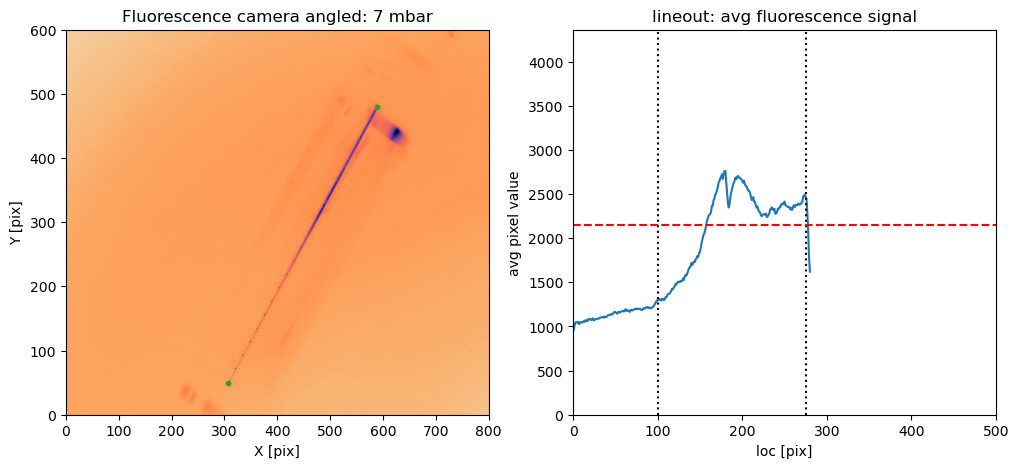

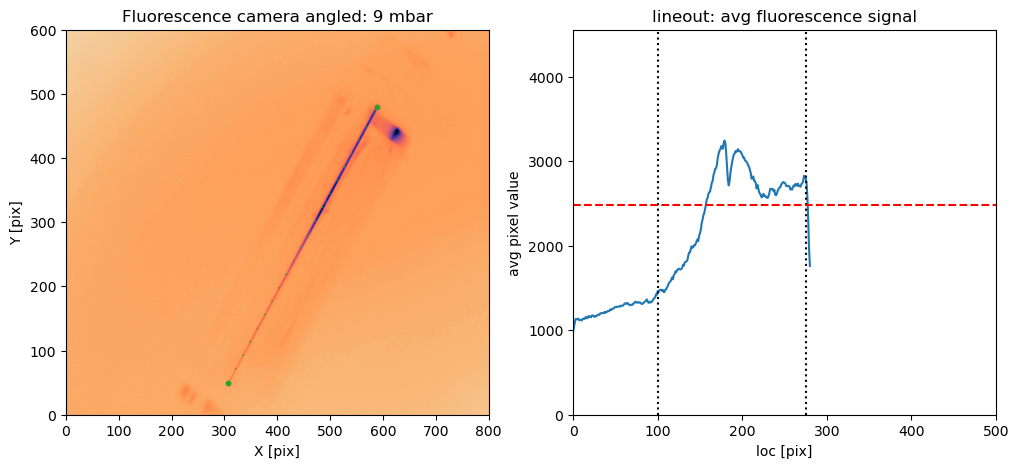

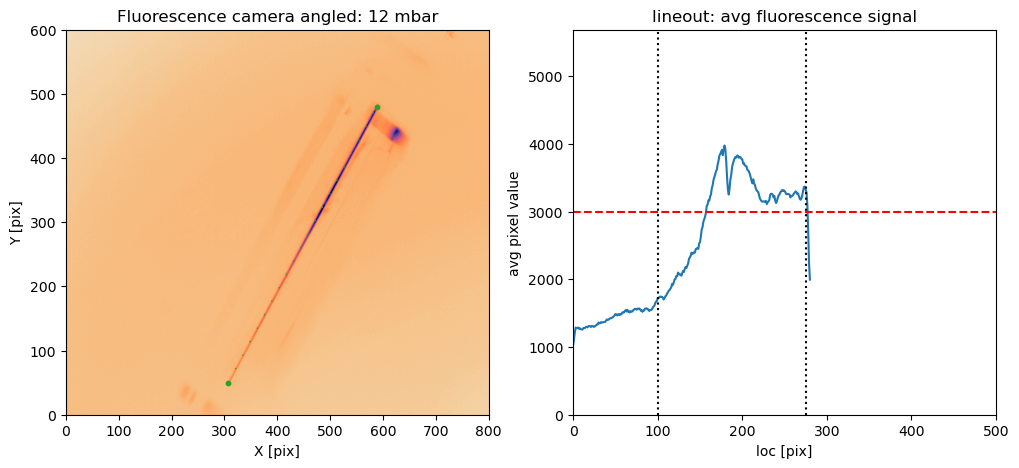

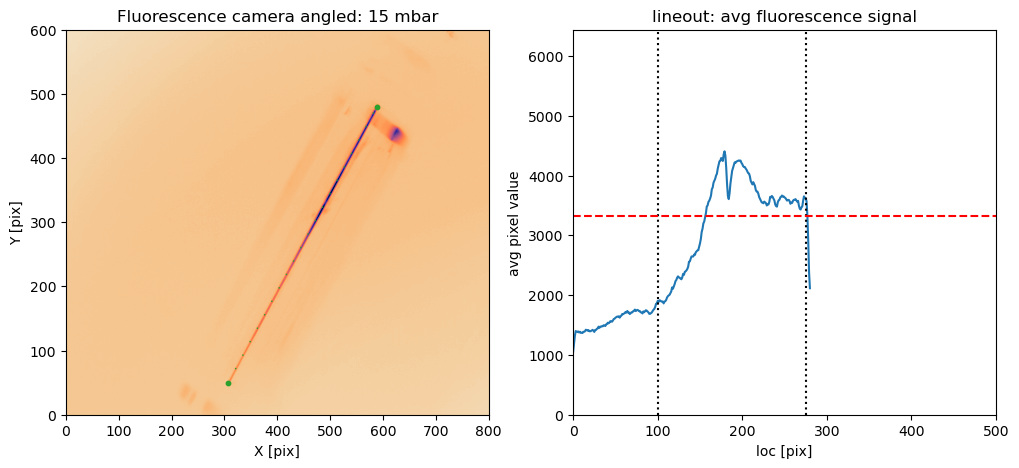

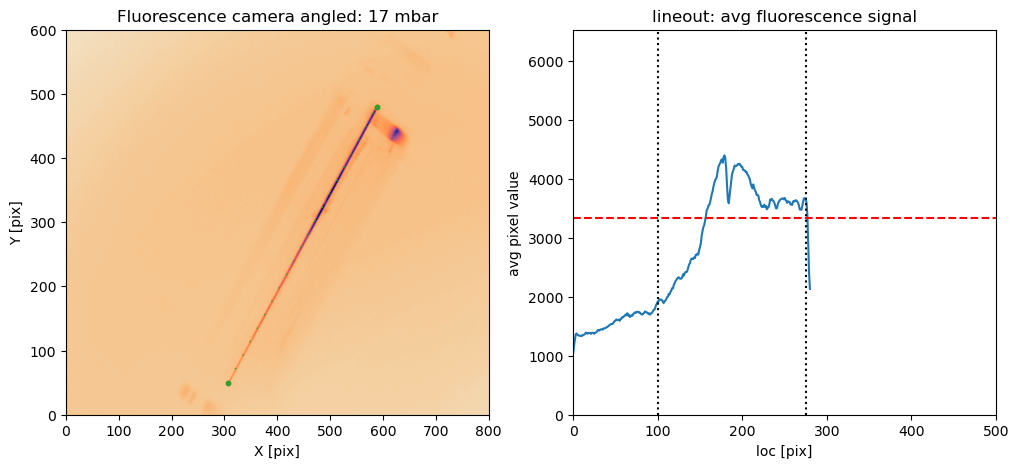

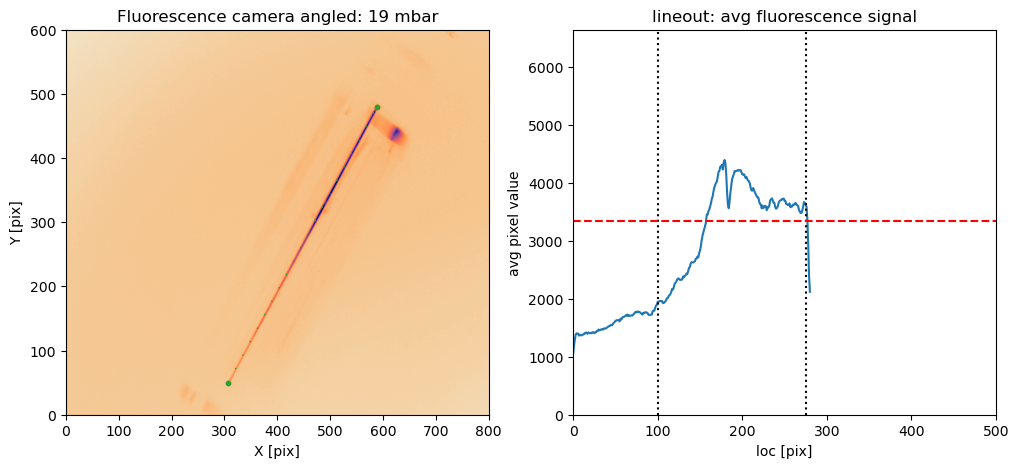

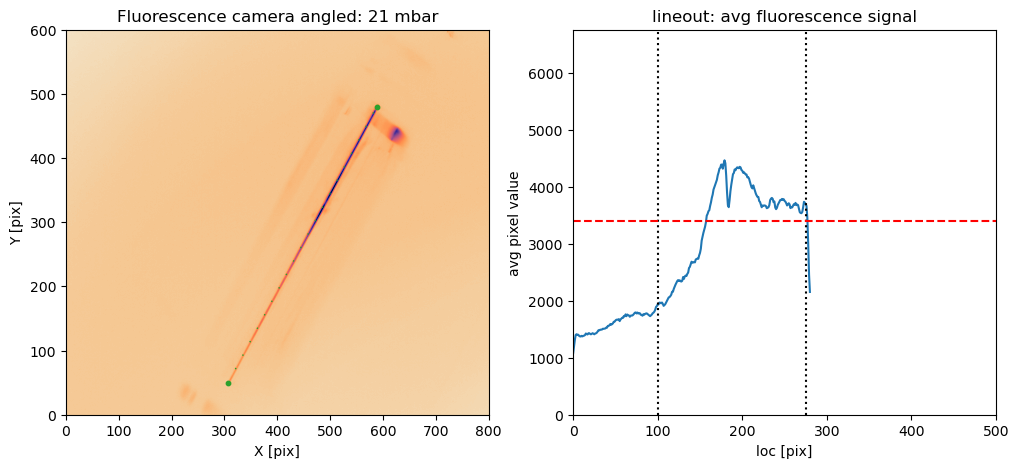

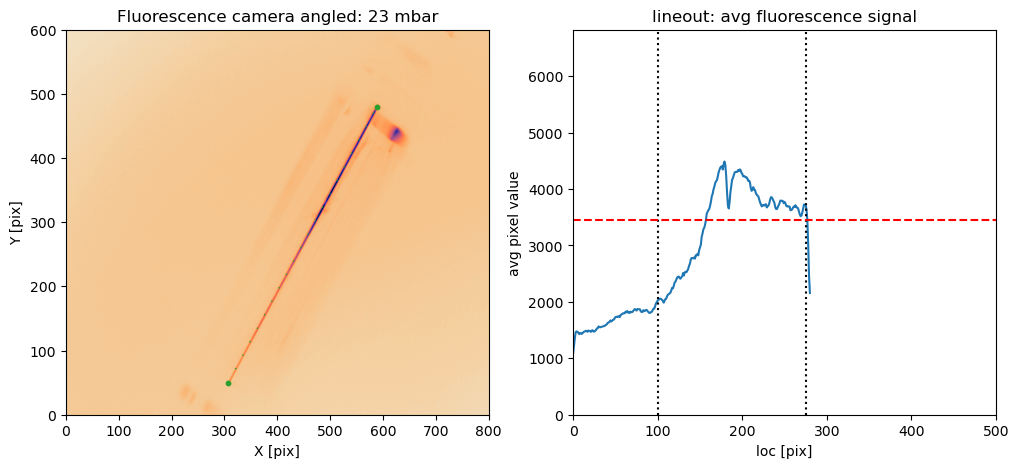

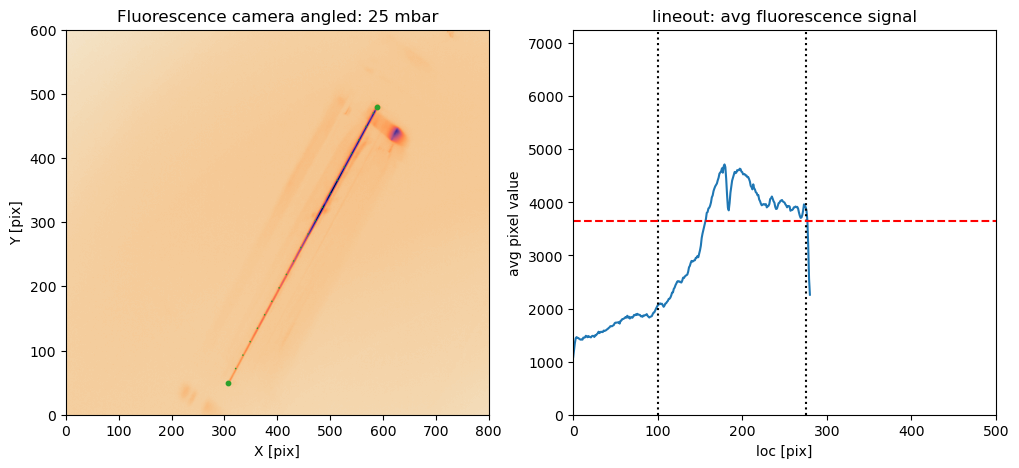

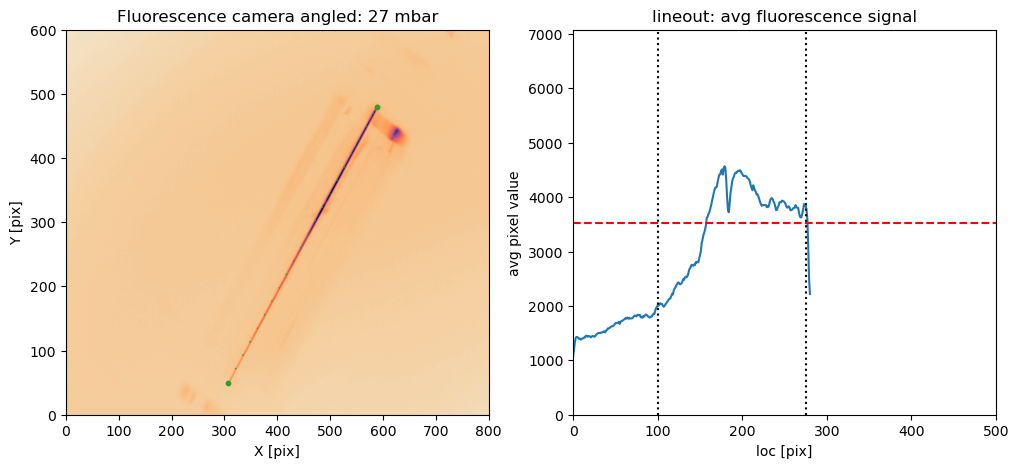

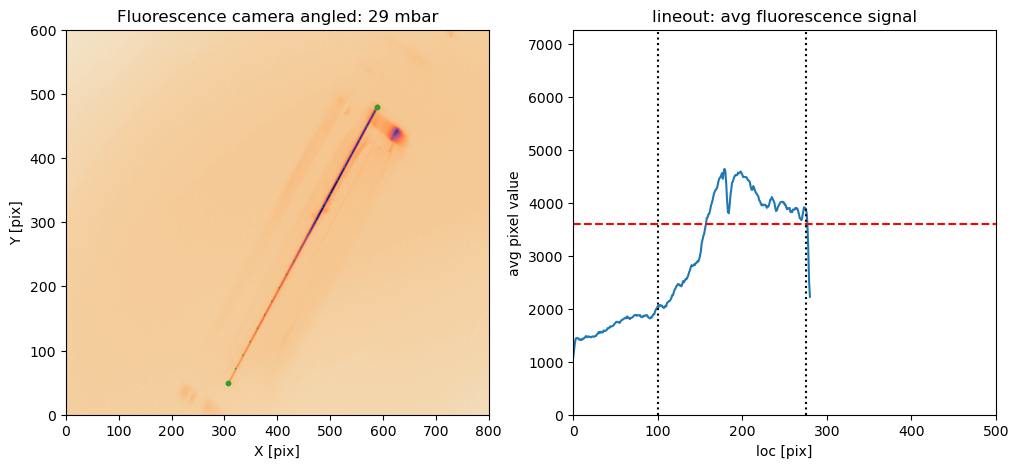

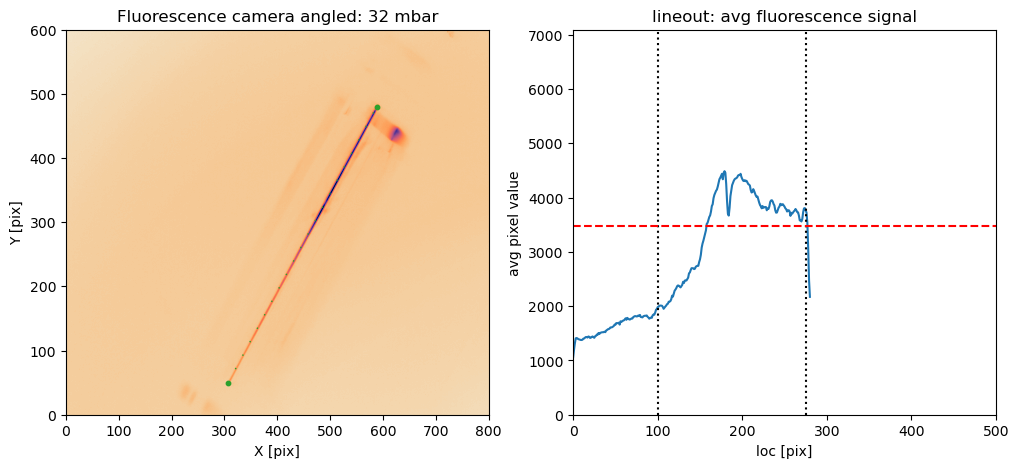

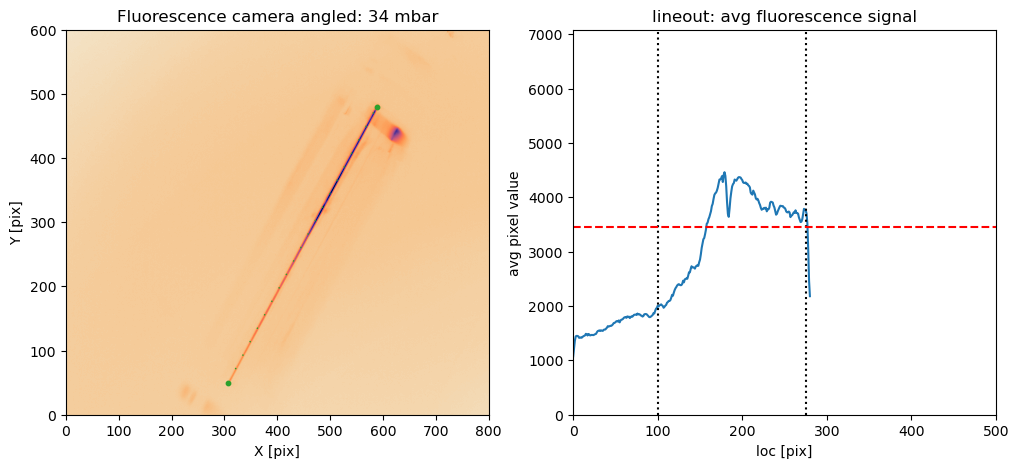

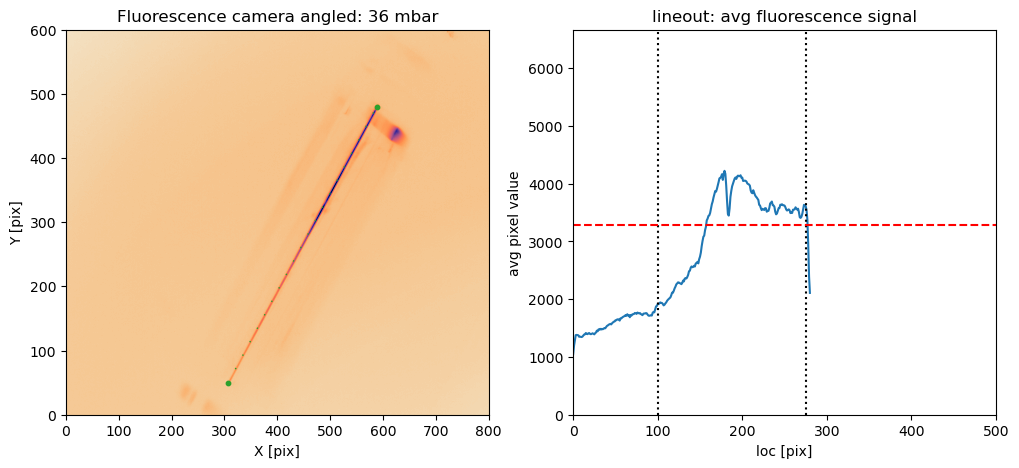

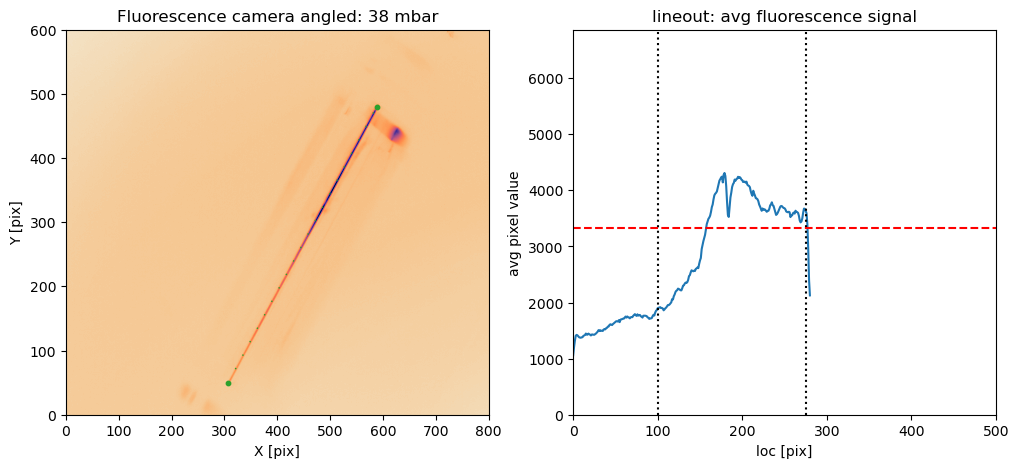

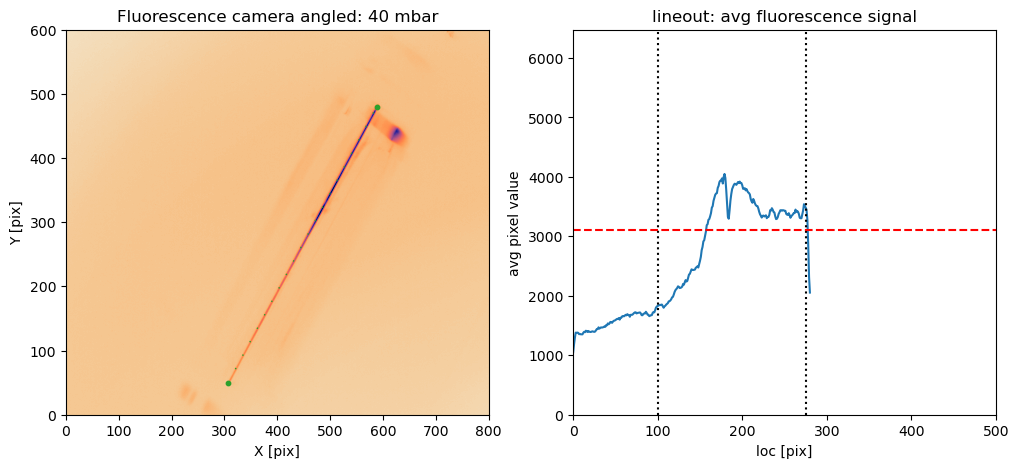

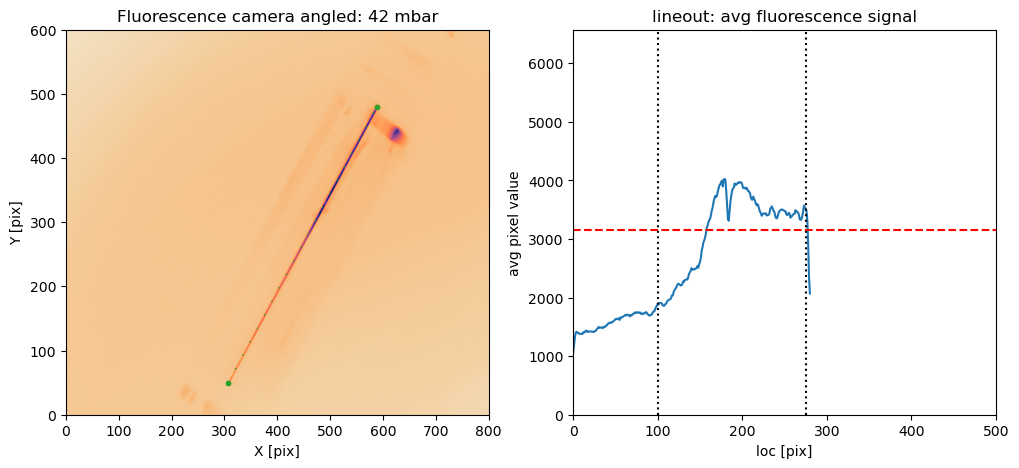

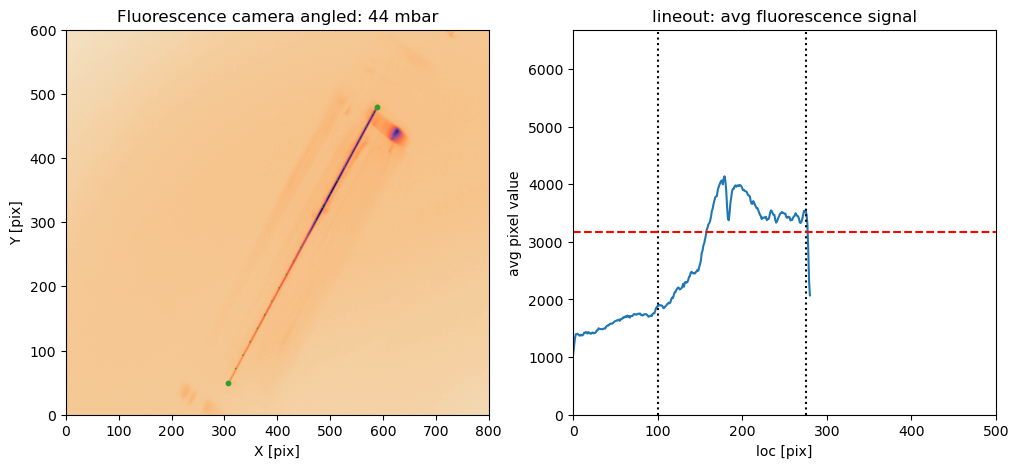

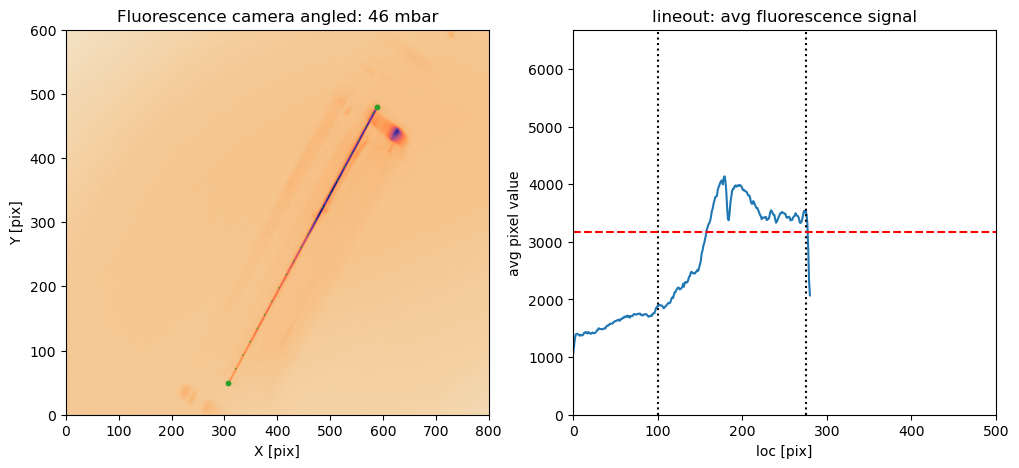

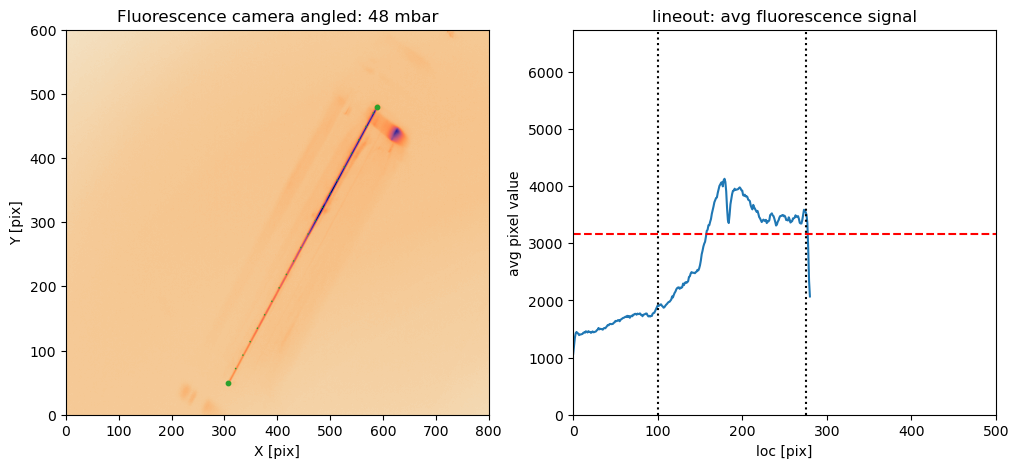

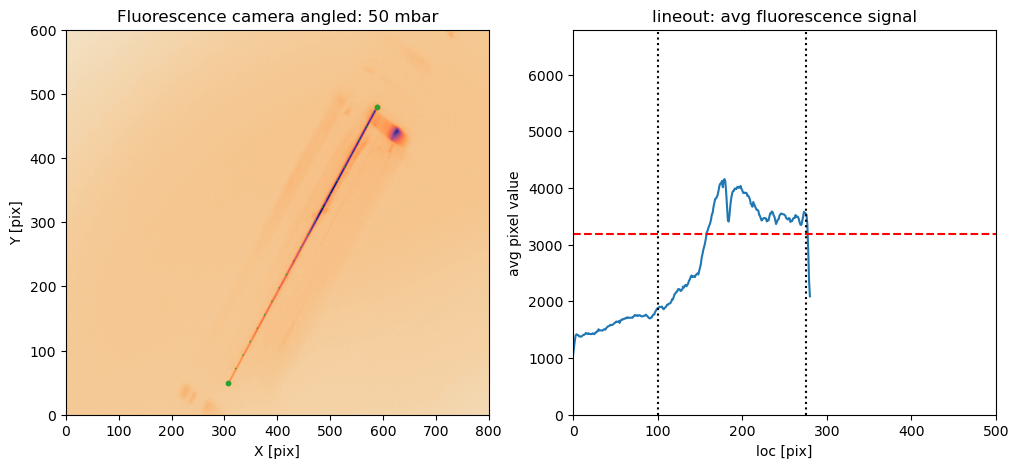

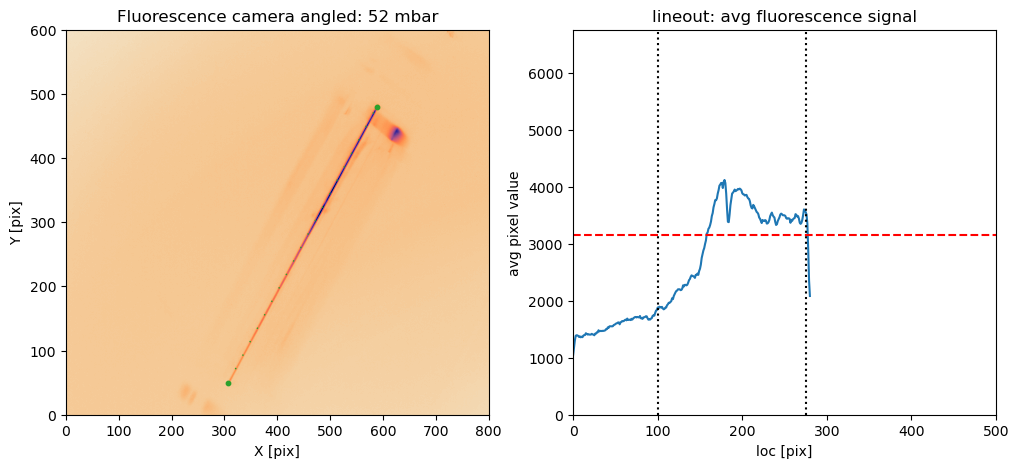

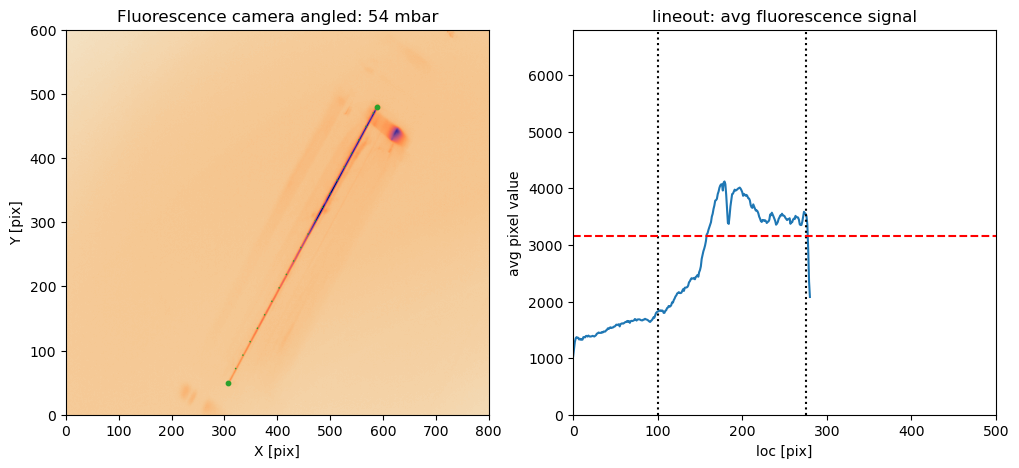

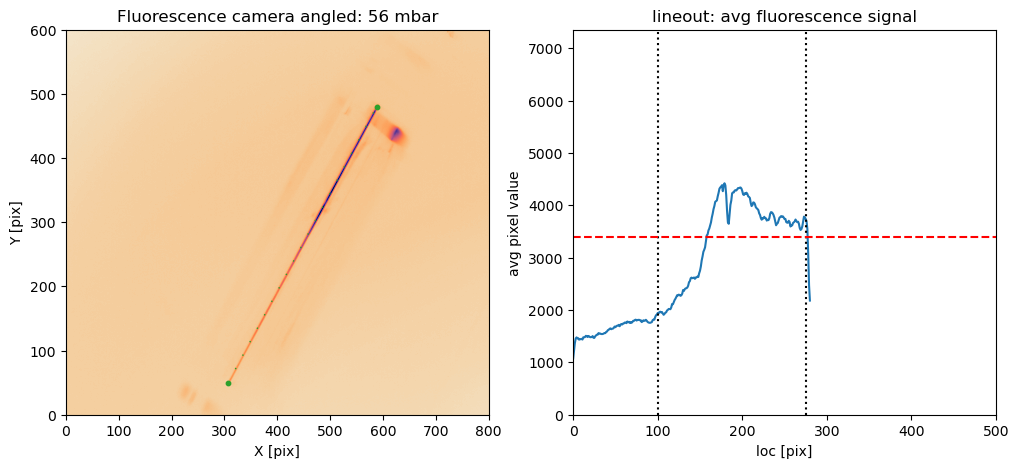

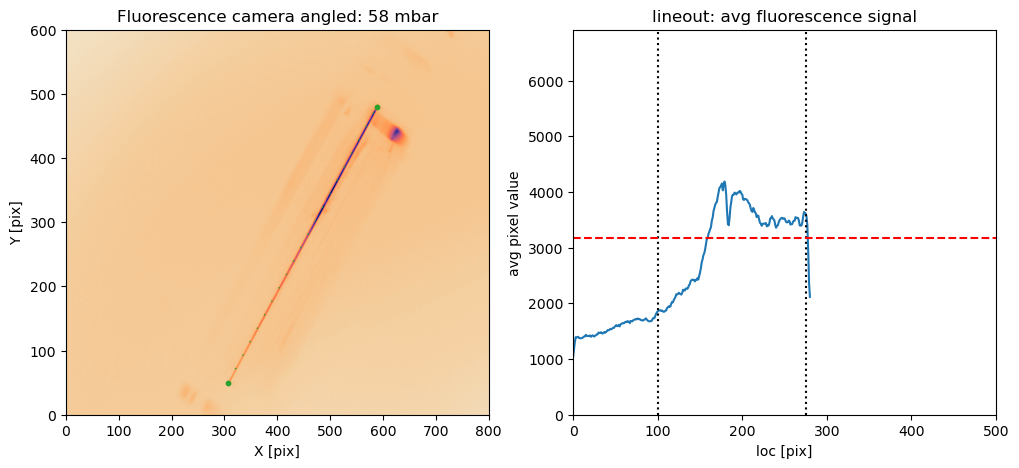

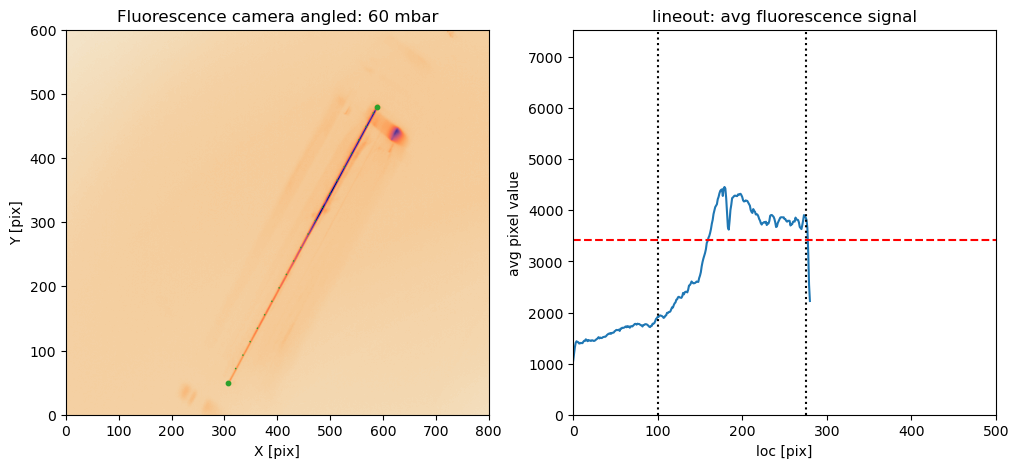

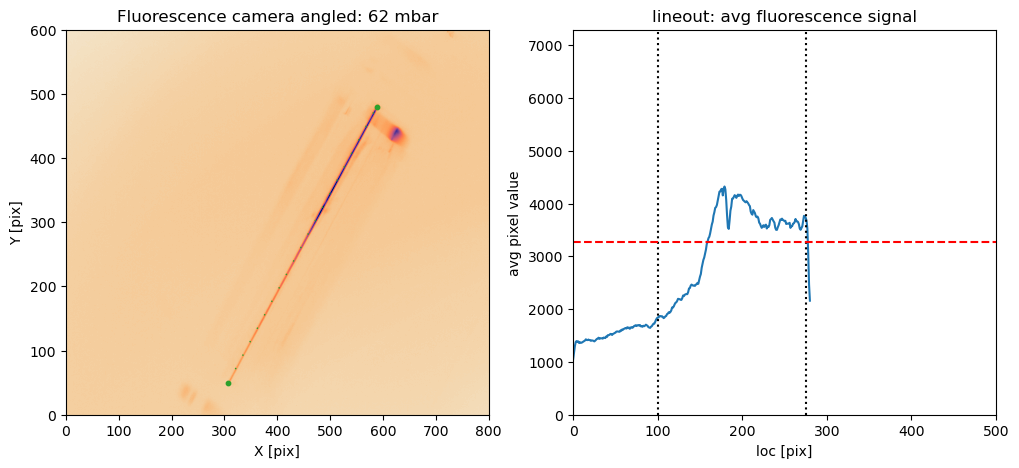

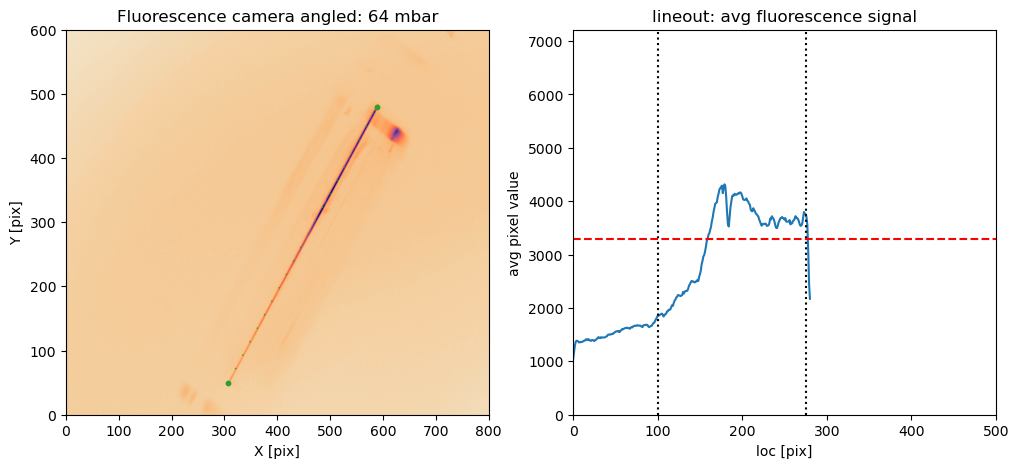

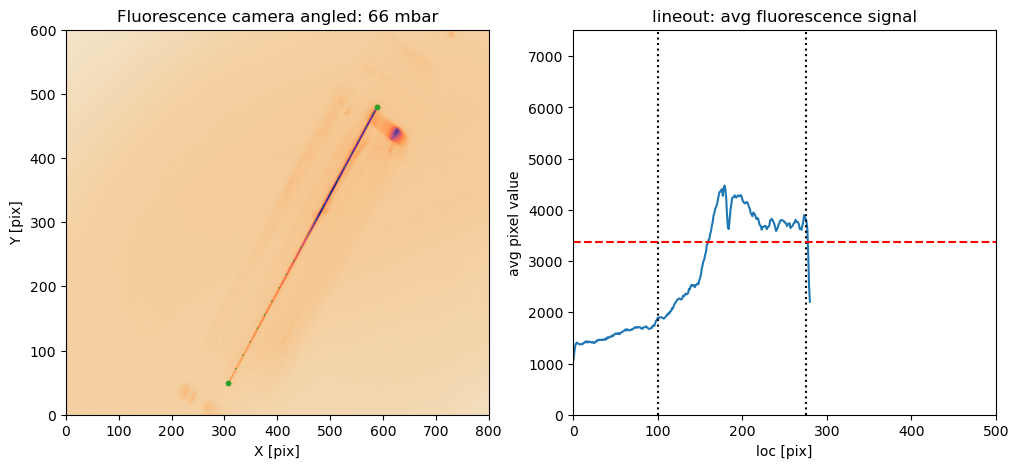

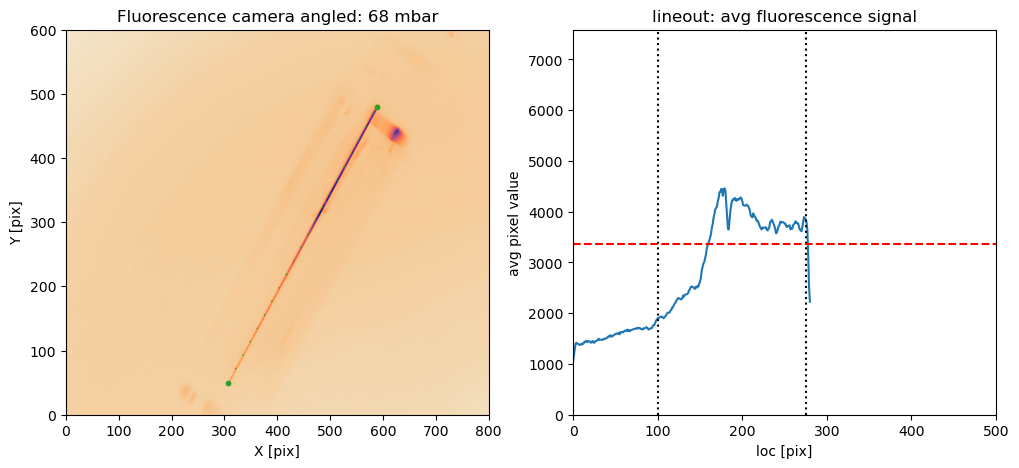

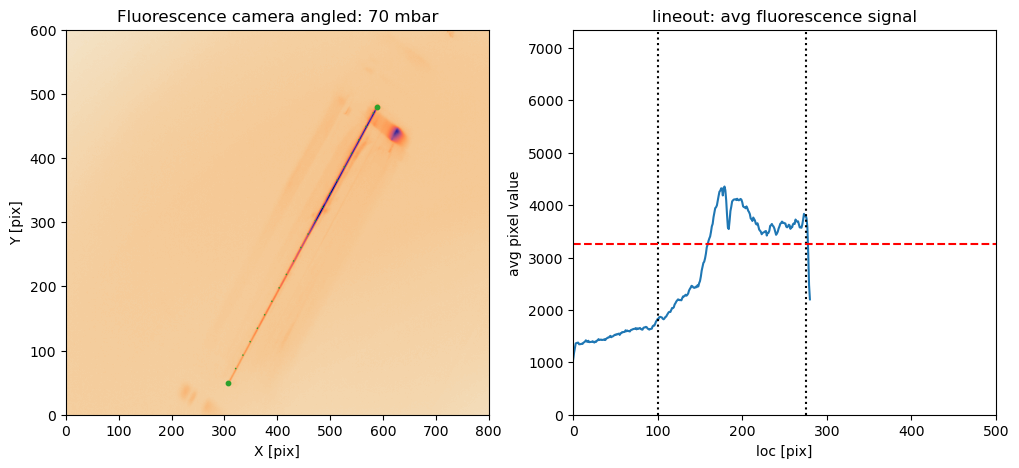

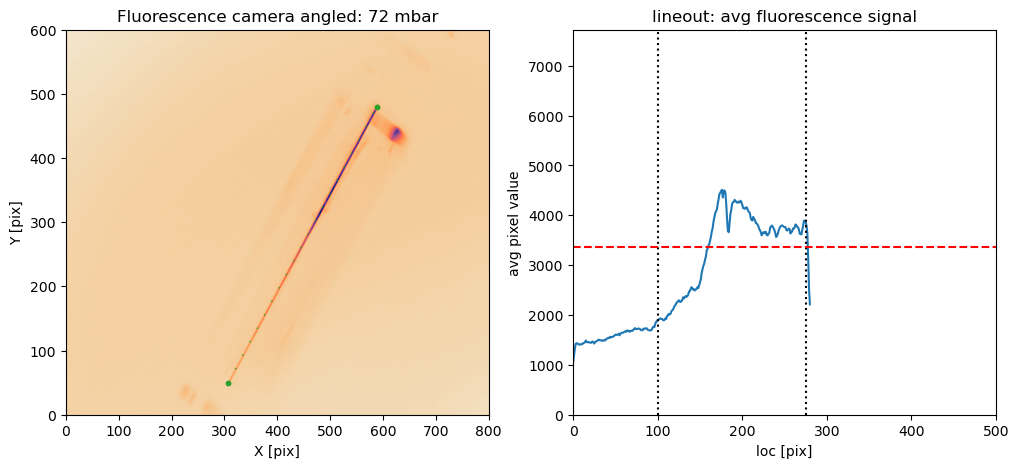

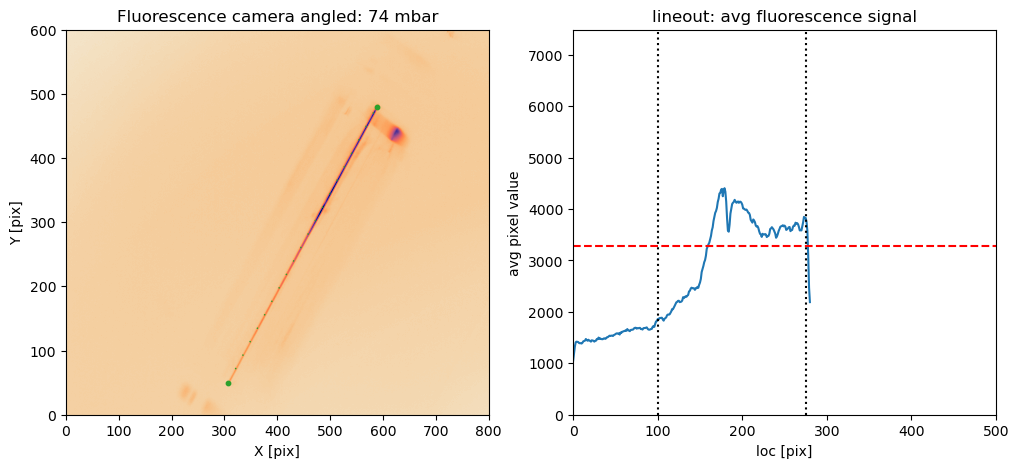

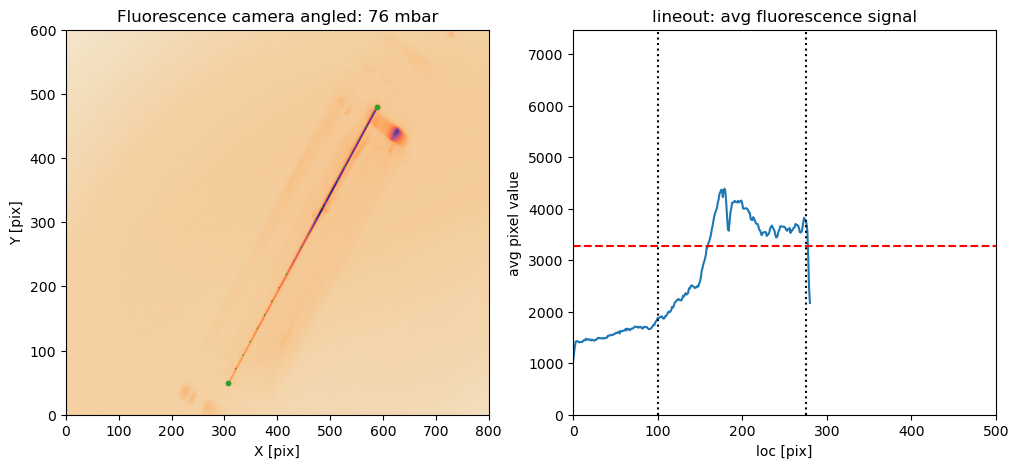

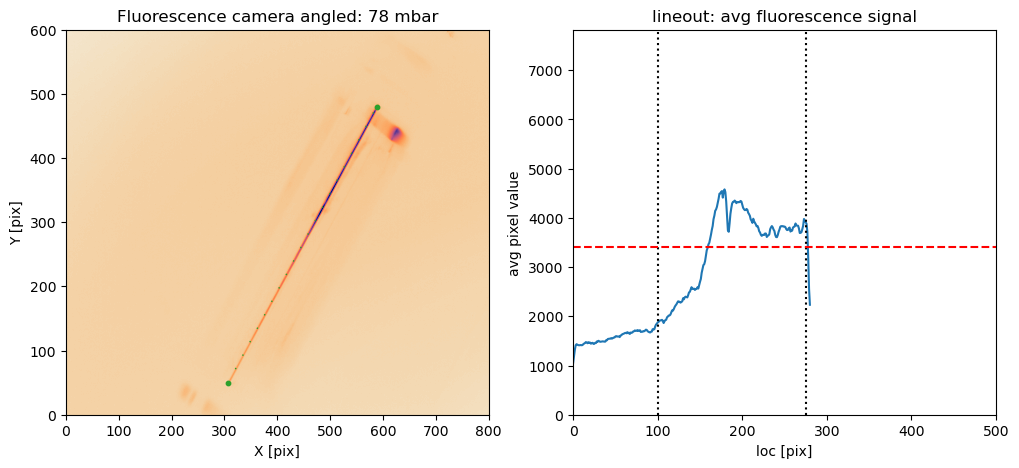

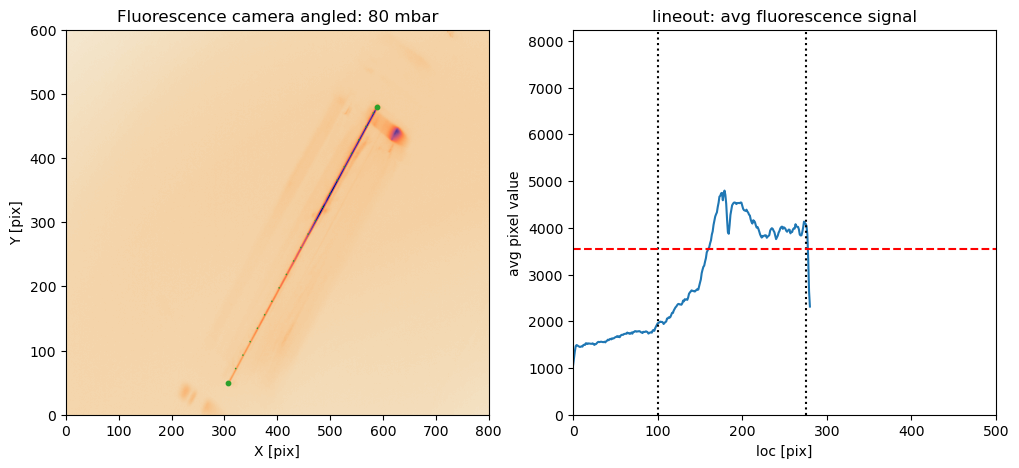

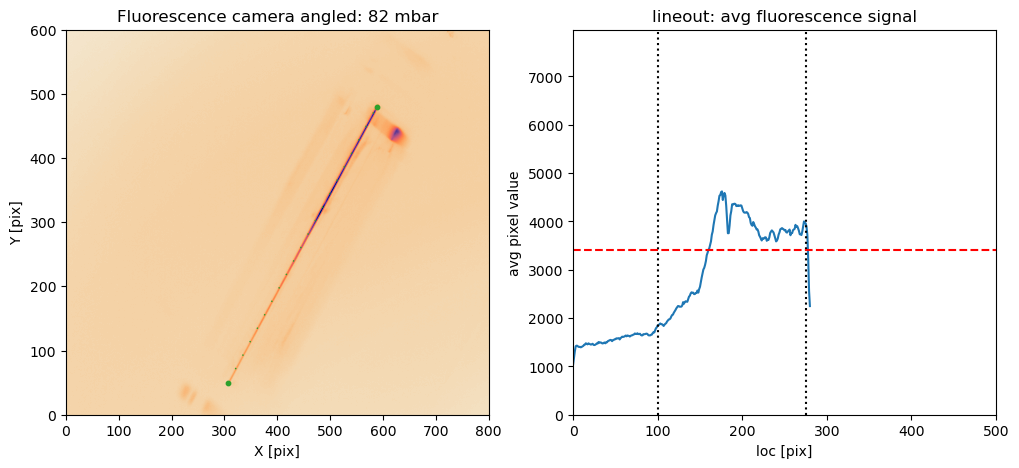

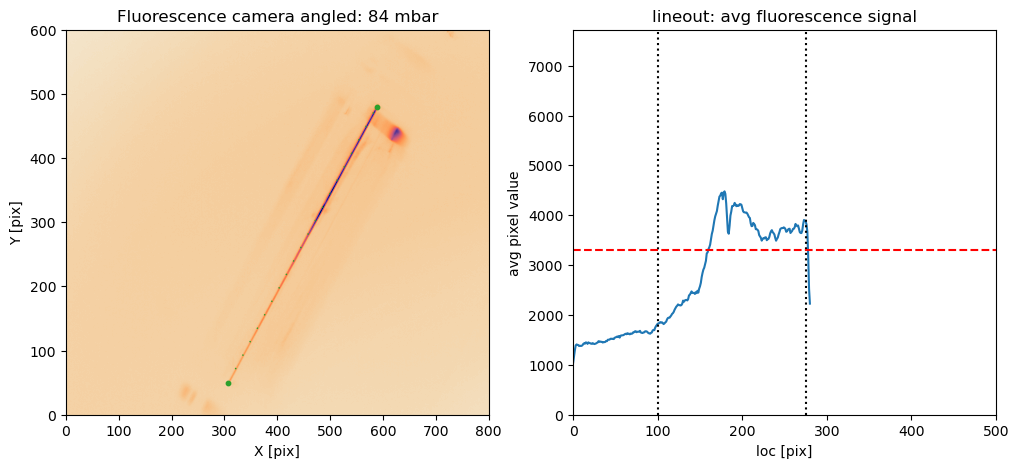

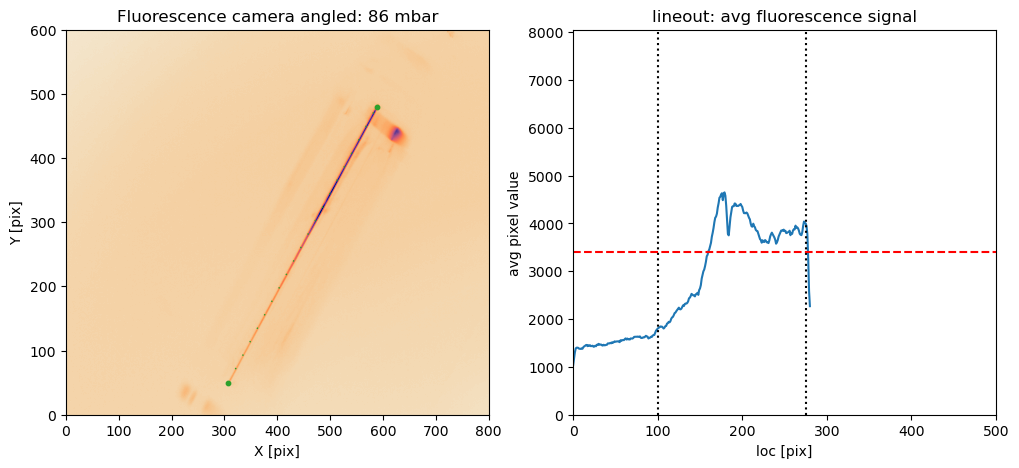

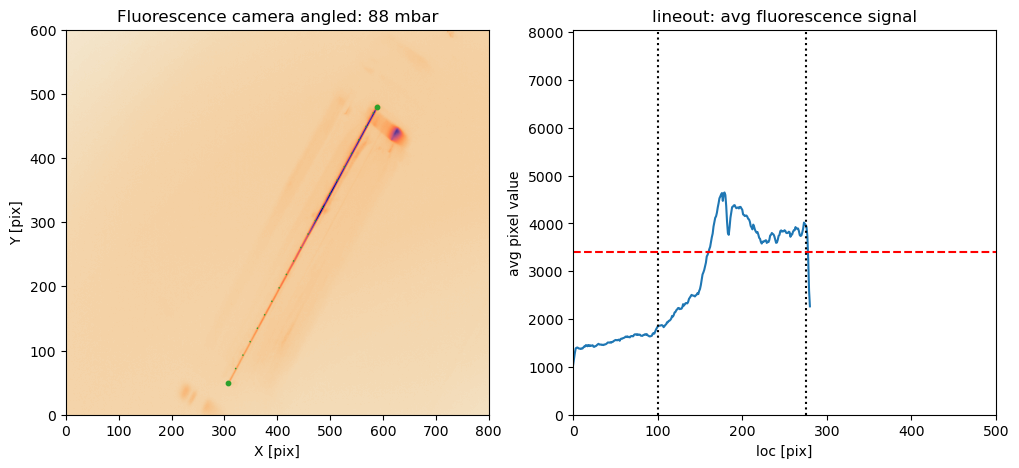

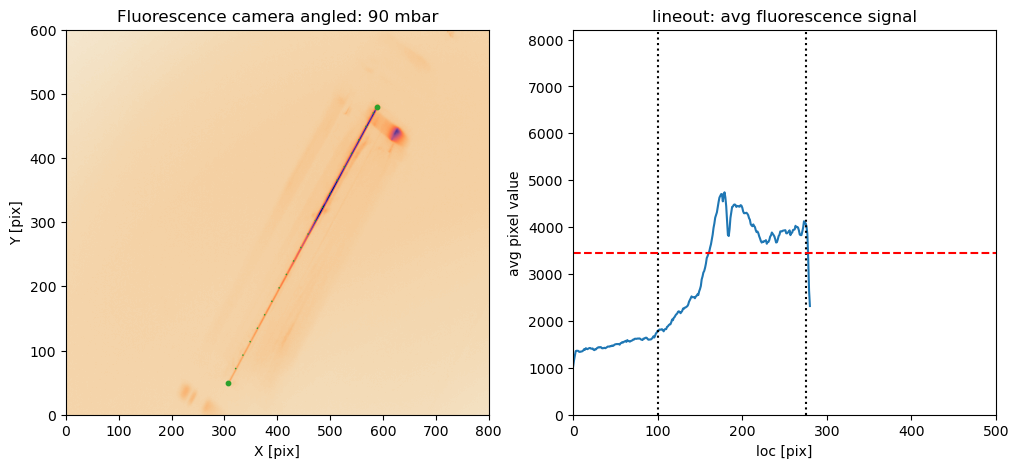

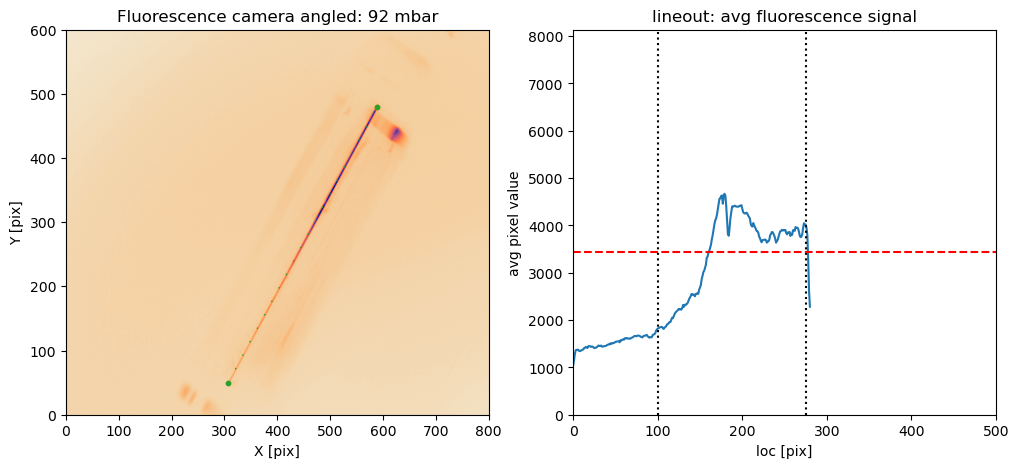

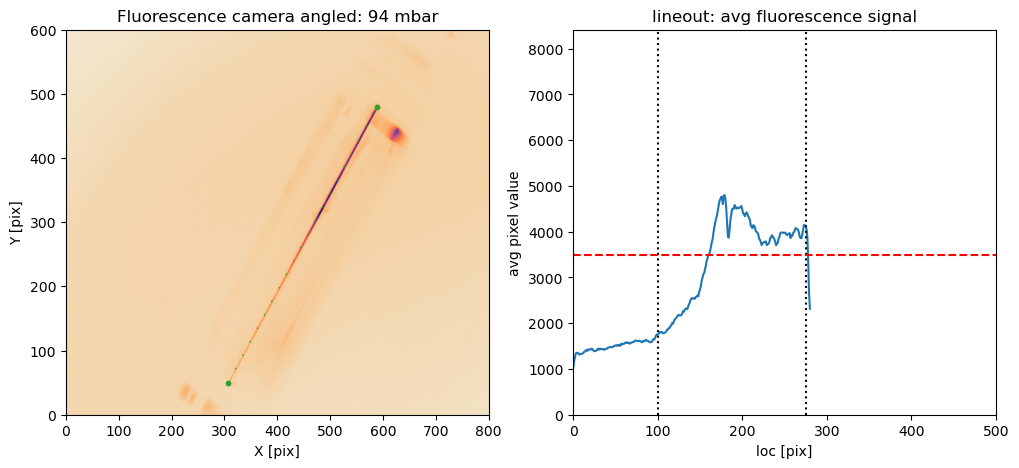

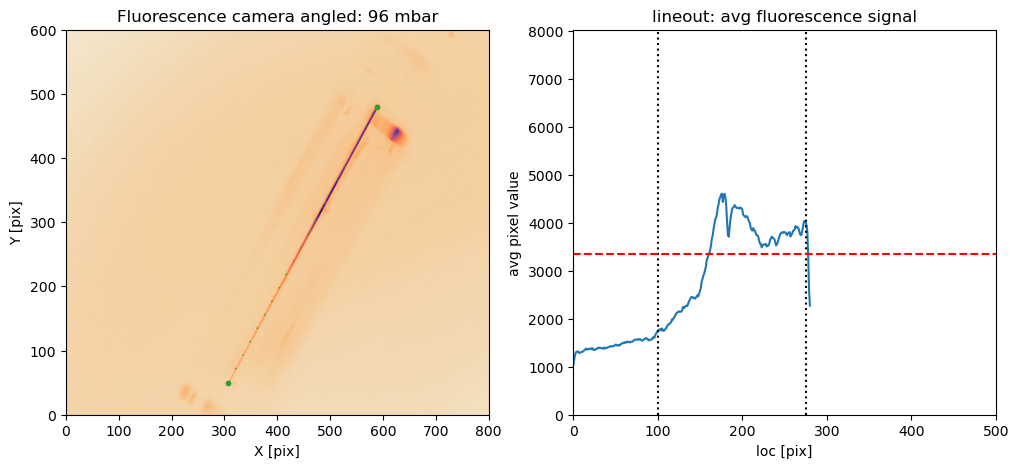

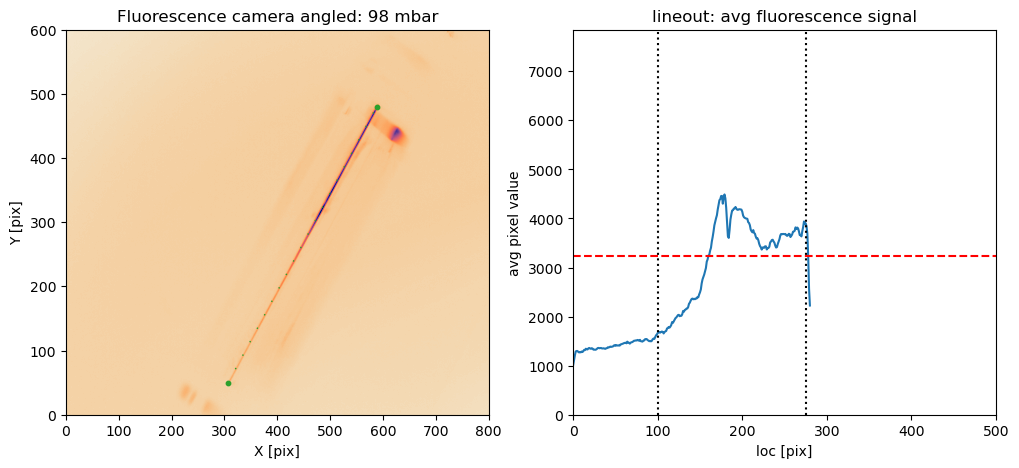

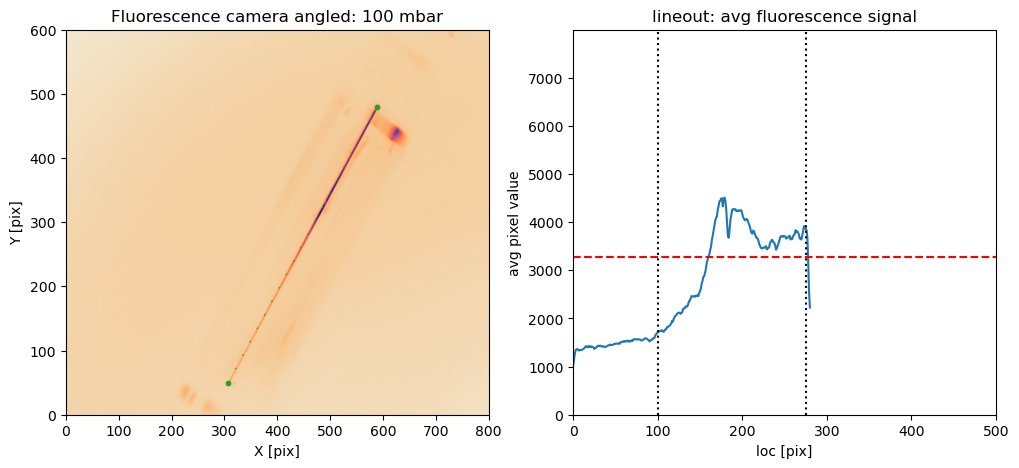

In [71]:
for pressure,i in zip(pressures,range(len(pressures))):
    shotlist = glob.glob(common_folder_path + str(pressure)+ r"mbar/*tif*")
    bg_shotlist = glob.glob(common_folder_path + r"/bg/*tif*")
    if len(shotlist) == 0:
        raise FileNotFoundError("Path to shots is not valid, Change!")
    else:
        img = cv2.imread(shotlist[0])
        avg_sigs[i] = get_avg_signal_angled(shotlist,
                                            bg_shotlist,
                                            plot_flag=True,
                                            title=str(pressure) + " mbar",
                                            max_pixel_value="auto",
                                            average_start_x=100,
                                            average_stop_x=275,
                                            coords_start=[307, 50],
                                            coords_stop=[588, 480])
print(avg_sigs)

[2153.6524     2481.75057143 3001.35822857 3331.42308571 3343.80508571
 3347.5192     3406.18565714 3449.70977143 3643.02365714 3528.92822857
 3598.66097143 3471.42714286 3455.56662857 3279.01828571 3326.5112
 3109.98862857 3161.87914286 3167.55868571 3167.55868571 3166.20108571
 3187.6488     3161.50394286 3157.60131429 3401.29908571 3169.13325714
 3415.1364     3275.1616     3288.11651429 3364.06514286 3369.8008
 3251.07291429 3371.63577143 3272.13817143 3282.3052     3409.00971429
 3551.85674286 3399.87331429 3307.87742857 3402.25302857 3396.05897143
 3448.20491429 3428.96268571 3488.93891429 3340.0188     3228.08085714
 3282.51354286]


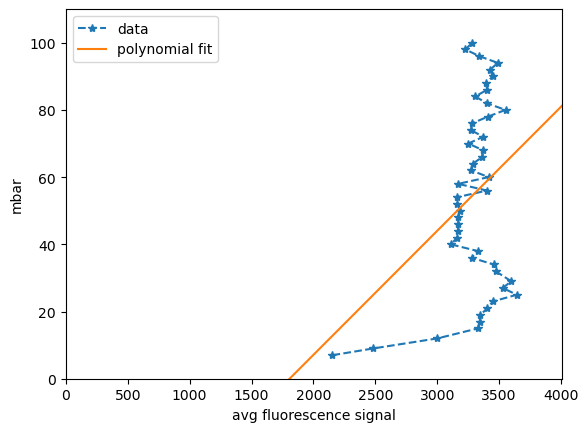

In [72]:
print(avg_sigs)

plt.plot(avg_sigs,pressures, '--*',label='data')
plt.ylabel('mbar')
plt.xlabel('avg fluorescence signal')

plt.xlim(0,1.1*max(avg_sigs))

mbar_per_sig = np.dot(avg_sigs,pressures) / np.dot(avg_sigs,avg_sigs)

xfit = np.linspace(0,1.1*max(avg_sigs),100)
yfit = mbar_per_sig*xfit

coeffs = np.polyfit(avg_sigs,pressures,1)
poly_func = np.poly1d(coeffs)


#plt.plot(xfit,yfit,label='fit')
plt.plot(xfit,poly_func(xfit),label='polynomial fit')
plt.ylim(0,110)

plt.legend()

AttributeError: 'NoneType' object has no attribute 'astype'

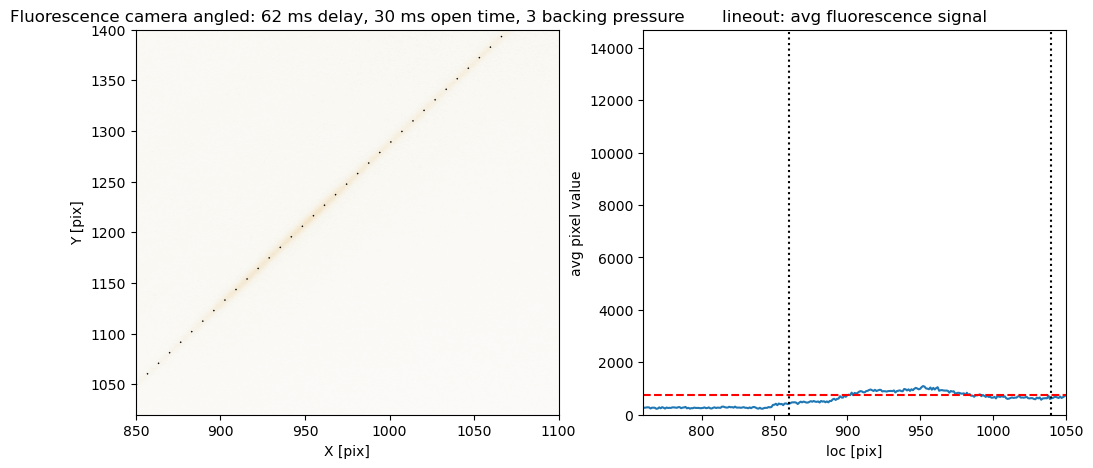

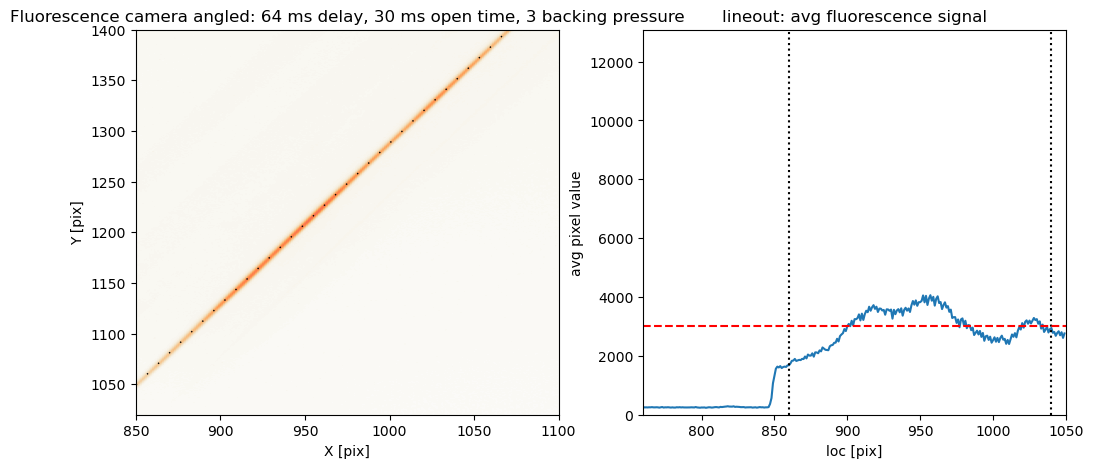

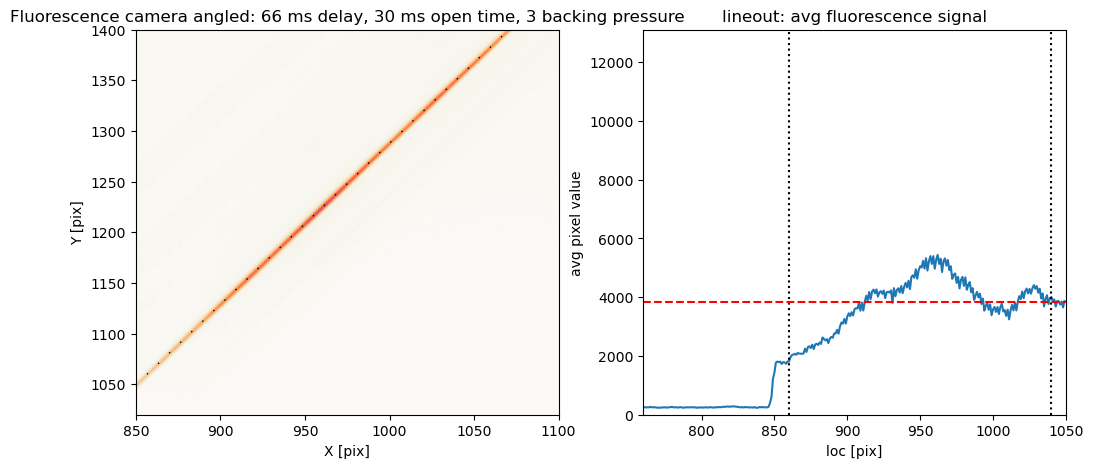

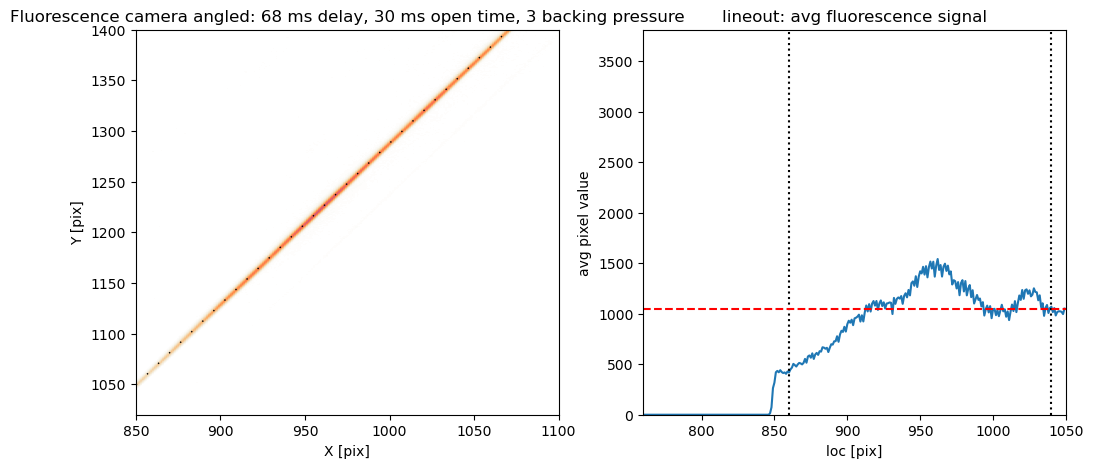

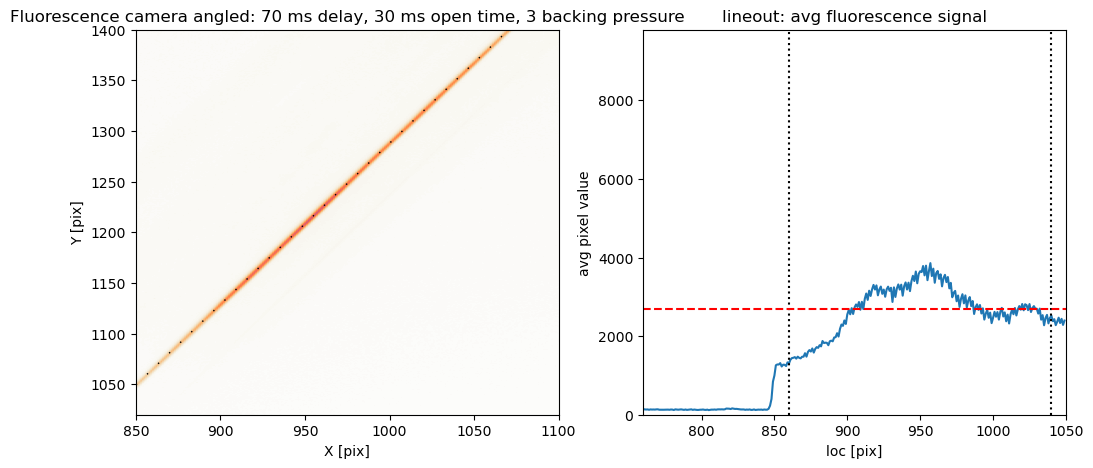

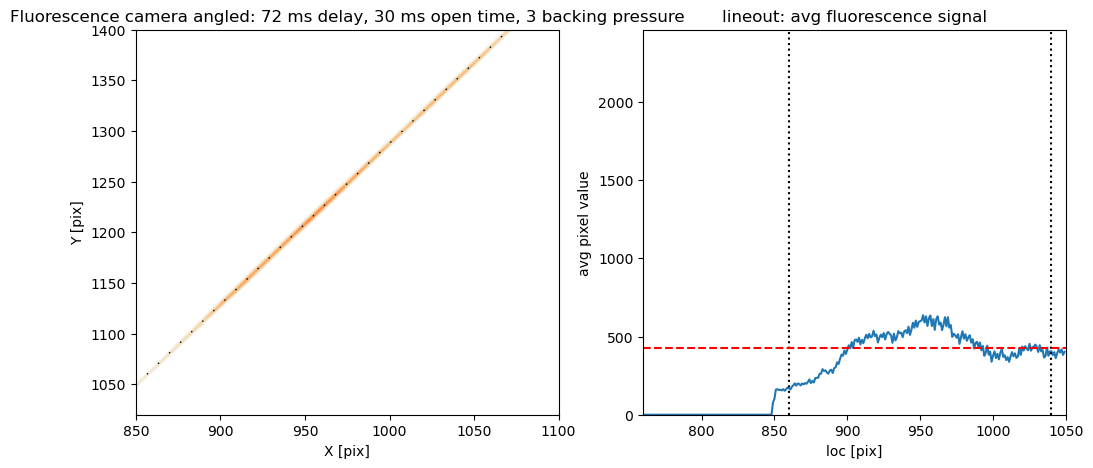

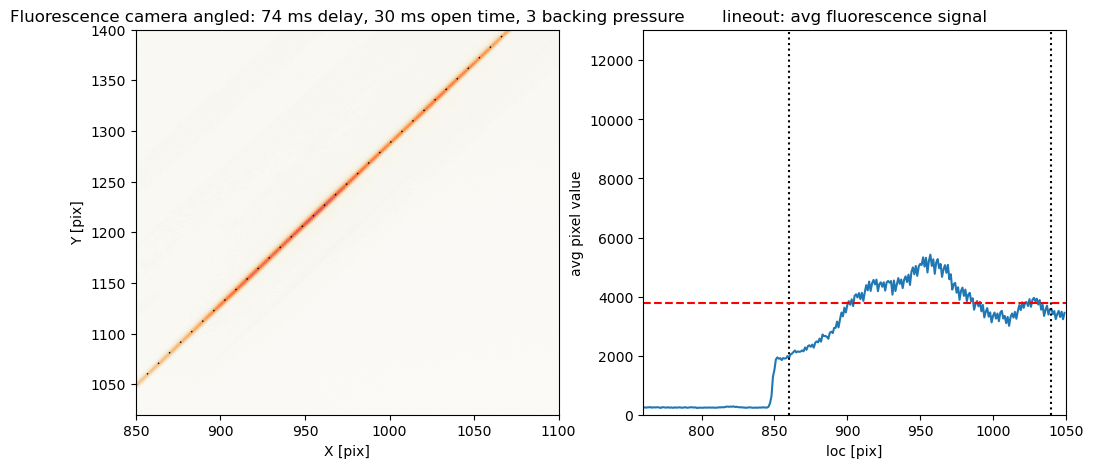

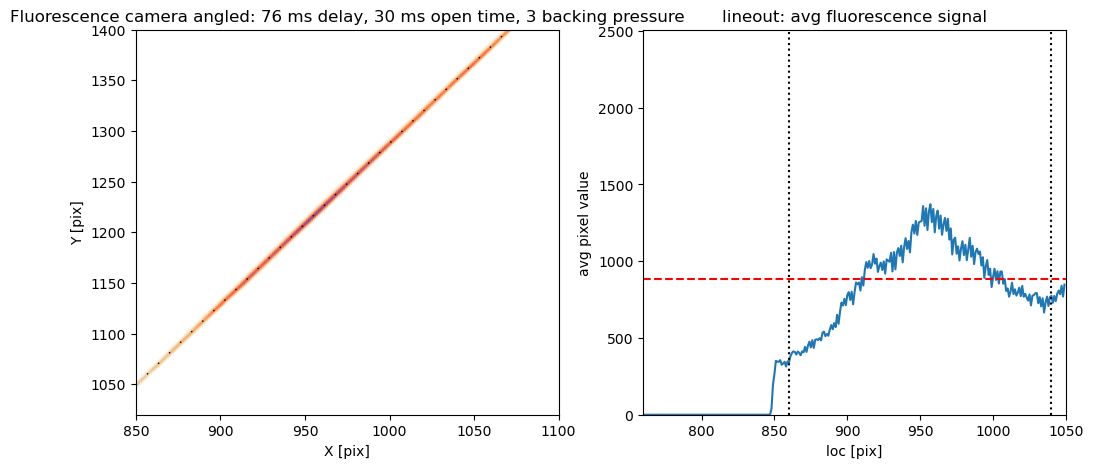

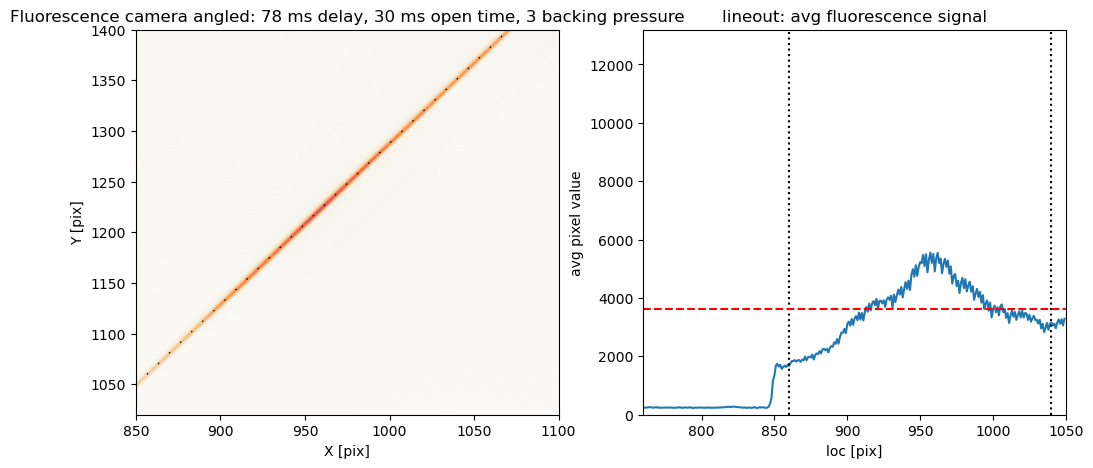

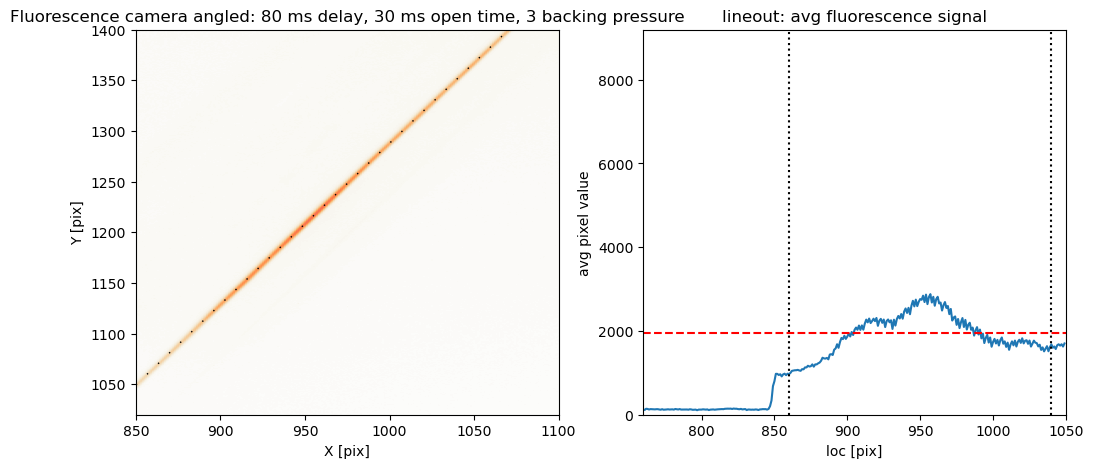

In [55]:
iota_delays = [62,64,66,68,70,72,74,76,78,80,81,82,84,86,88]
iota_open_ms = [30] #opening times of the iota gas jet [ms]
iota_BPs = [3,6]

results_cube = np.zeros((len(iota_delays), len(iota_open_ms), len(iota_BPs))) #create an empty 3D array which will contain the data


for iota_delay,i in zip(iota_delays,range(len(iota_delays))):
    for iota_open_time, j in zip(iota_open_ms, range(len(iota_open_ms))):
        for iota_BP, k in zip(iota_BPs, range(len(iota_BPs))):
            shotlist = glob.glob(common_folder_path + '/' +str(iota_BP) +'barBP/jet' + str (iota_open_time)+ "ms/" +str(iota_delay) + r"msdel/*tif*")
            p=iota_delays.index(iota_delay)
            q=iota_open_ms.index(iota_open_time)
            r=iota_BPs.index(iota_BP)
            
            results_cube[p,q,r] = get_avg_signal_angled(shotlist, bg_shotlist,
                                                        plot_flag=True,
                                                        title=str(iota_delay) + " ms delay, " + str(iota_open_time) + " ms open time, " + str(iota_BP)+ " backing pressure",
                                                        max_pixel_value="auto",
                                                        average_start_x=860,
                                                        average_stop_x=1040)

21.396730454054275
54.95068028019337


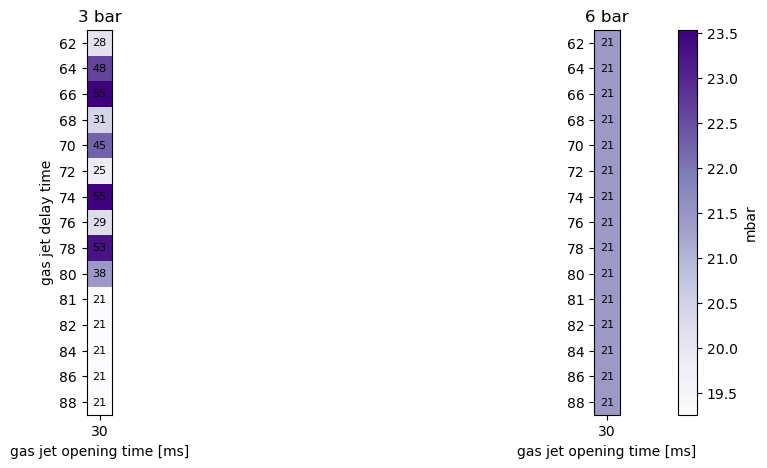

In [56]:
# Create a sample 3D array of values
array_3d = np.vectorize(poly_func)(results_cube)
array_3d=array_3d.clip(min=0)

min_value = np.min(array_3d)
max_value = np.max(array_3d)

print(min_value)
print(max_value)

# Create subplots for each 2D slice
fig, axs = plt.subplots(1, array_3d.shape[2], figsize=(15, 5))  # Adjust figsize as needed

cmap = "Purples"
# Plot each 2D slice
for i in range(array_3d.shape[2]):
    axs[i].imshow(array_3d[:, :, i], cmap=cmap, vmin=min_value, vmax=max_value)  # You can use any colormap you prefer
    axs[i].set_title(f"{iota_BPs[i]} bar")
    #axs[i].axis('off')  # Hide axis labels

    # Add text annotations
    for y in range(array_3d.shape[0]):
        for x in range(array_3d.shape[1]):
            if array_3d[y, x, i] > 0.1:
                axs[i].text(x, y, f'{array_3d[y, x, i]:.0f}', color='black', ha='center', va='center',fontsize=8)
    

    axs[i].set_xticks(np.arange(array_3d.shape[1]))
    axs[i].set_xticklabels(iota_open_ms)
    axs[i].set_yticks(np.arange(array_3d.shape[0]))
    axs[i].set_yticklabels(iota_delays)

    axs[i].set_xlabel('gas jet opening time [ms]')

axs[0].set_ylabel('gas jet delay time')

# Add color bar
cbar = fig.colorbar(axs[-1].imshow(array_3d[:, :, -1], cmap=cmap), ax=axs.ravel().tolist())
cbar.set_label('mbar')
